# Handling unknown words

The term _unknown words_ refers to words that might appear during evaluation and testing, but they were not present during training, so the model does not include any representation of them. Consider the following toy train and test sets, where the words 'John' and 'dislikes' occur only in the test data:

In [1]:
train_data = ['Alice loves Bob', 'Alice hates Charlie', 'Bob loves Jim']
test_data = ['Jim dislikes Bob', 'John loves Alice']

A common technique to handle unknown words is to replace all _rare_ words in your training data (e.g. words that occur less than 3 times) with a special token `UNK`, and then learn a representation for this as you do with any other token. This representation can be used during evaluation in place of all unknown words in your test data. `lambeq` simplifies this process with the help of a special rewrite rule, `UnknownWordsRewriteRule`, which works as follows:

1. Create a vocabulary from the train data, based on a minimum frequency for each word.
2. Replace all words in the train data that are not included in the vocabulary with `UNK`, and do the training as usual
3. Replace all words in the test data that are not included in the vocabulary with `UNK`, and do the testing as usual.

The following sections show how to use this rule in practice, first for models that are not based on syntax (such as the `spiders_reader`), and then for the slightly more complicated case of syntax-based models.

## Handling unknown words in syntax-free models

In syntax-free models, such as the spiders reader and the stairs reader, each word has a single representation, no matter in how many different grammatical roles the word appears in the data. For example, consider the word "play"; although it could appear both as a noun and a verb, in a typical syntax-free model there would be just a single representation of the word. Let's look at a concrete example, using a spiders reader, `lambeq`'s equivalent of a bag-of-words model.

In [2]:
from lambeq import spiders_reader

train_data = [
    "Alice loves cats",
    "Bob loves Alice",
    "Alice hates dogs",
    "Bob hates cats"
]
test_data = [
    "Bob dislikes dogs", 
    "Bob loves mice"
]

# Create the diagrams from the data
train_diagrams = spiders_reader.sentences2diagrams(train_data)
test_diagrams = spiders_reader.sentences2diagrams(test_data)

We will now create an `UnknownWordRewriteRule` and we will use it to generate a vocabulary from the train data, with all words that occur _at least 2 times_. This can be done with the class method `from_diagrams`:

In [3]:
from lambeq import UnknownWordsRewriteRule

unk_wrd_rule = UnknownWordsRewriteRule.from_diagrams(
    diagrams=train_diagrams,
    min_freq=2,
    ignore_types=True
)

# Show vocabulary
unk_wrd_rule.vocabulary

{'Alice', 'Bob', 'cats', 'hates', 'loves'}

Note that the word "dogs" is not included in this vocabulary, since it occurs only once in the train data, so it doesn't meet the inclusion condition. Further, notice that the parameter `ignore_types` is set to True, which forces the rewrite rule to ignore differences that occur only in the grammatical type of the token.

In order to use the rewrite rule in practice, we need to pass it to a `lambeq` rewriter and apply it on the train and test data.

In [4]:
from lambeq import Rewriter

rewriter = Rewriter([unk_wrd_rule])

# Replace rare/unknown words with UNK
rewritten_train_diagrams = [rewriter(d) for d in train_diagrams]
rewritten_test_diagrams = [rewriter(d) for d in test_diagrams]

# Training
# ... 

# Testing
# ...

Let's examine the results on the train set:

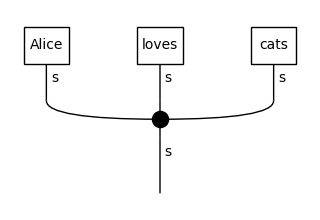

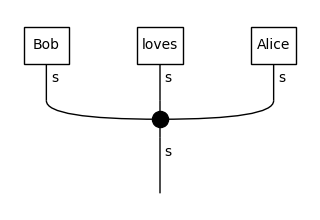

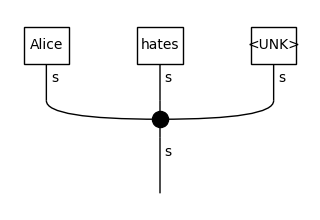

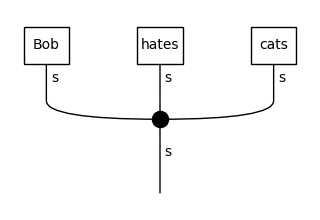

In [5]:
for d in rewritten_train_diagrams:
    d.draw(figsize=(3,2))

In the third diagram, "dogs" is replaced by `UNK`, since it appeared in the train data only once, so it was considered a rare word and thus was not included in the vocabulary. We can now use these diagrams for training, so the model will learn a representation for the `UNK` token equally as for every other word.

Let's now have a look at the test diagrams:

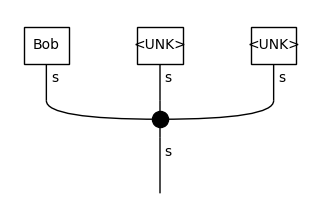

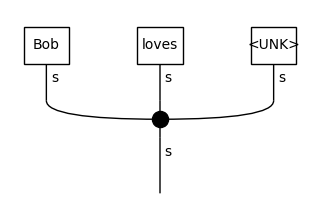

In [6]:
for d in rewritten_test_diagrams:
    d.draw(figsize=(3,2))

Every word that was not included in the original vocabulary created from the train data is now replaced with the `UNK` token, and it will use the learned representation of that token.

## Handling unknown words in syntax-based models

In syntax-based models, such as DisCoCat, words are added to the vocabulary based on both their surface form _and_ the grammatical type in which they occur in the data. This means that it is possible to have more than one `UNK` token in your vocabulary, and even that a token that occurs under different grammatical roles (e.g. "play" as a verb and "play" as a noun) could be replaced by different `UNK` tokens depending on the type of each occurrence. In the following example, we use BobcatParser to create DisCoCat diagrams for a toy dataset.

In [7]:
from lambeq import BobcatParser

train_data = [
    "children play hide-and-seek",
    "musicians play music",
    "a theatrical play",
    "music for children",
    "a play for musicians"
]

test_data = [
    "play ball",
    "nice play"
]


parser = BobcatParser()
train_diagrams = parser.sentences2diagrams(train_data)
test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences:   0%|          | 0/2 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/5 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/5 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/1 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/2 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/2 [00:00<?, ?it/s]

We will apply the same rule as before, with the difference that now the `ignore_types` parameter is set to False, which means that the type of each token is also taken into account.

In [8]:
unk_wrd_rule = UnknownWordsRewriteRule.from_diagrams(
    diagrams=train_diagrams,
    min_freq=2,
    ignore_types=False
)

# Print vocabulary
for tok, typ in unk_wrd_rule.vocabulary:
    print(tok,':',str(typ))

for : n.r @ n @ n.l
play : n
play : n.r @ s @ n.l
a : n @ n.l
music : n
children : n
musicians : n


Note that the word "play" has two representations in the vocabulary: one as a transitive verb with type `n.r @ s @n.l`, and one as a simple noun. These two tokens are considered different in a syntax-based model. Let's use this vocabulary to introduce `UNK` tokens in the train and test diagrams.

In [9]:
rewriter = Rewriter([unk_wrd_rule])

rewritten_train_diagrams = [rewriter(d) for d in train_diagrams]
rewritten_test_diagrams = [rewriter(d) for d in test_diagrams]

When examining the training diagrams, we can see two different `UNK` tokens being added: one for nouns (first diagram) and one for adjectives (third diagram). This is because the corresponding words ("hide-and-seek", "theatrical") occurred only once in the train data, so they were not included in the vocabulary.

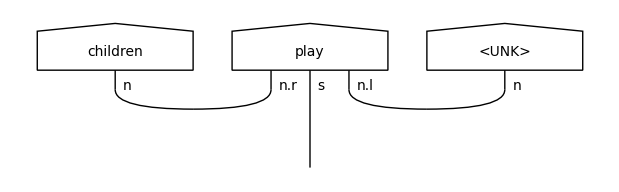

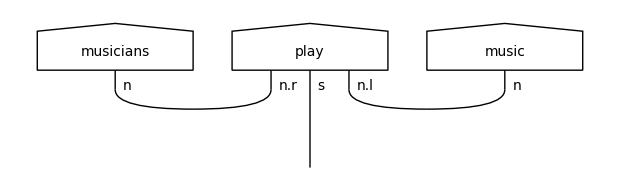

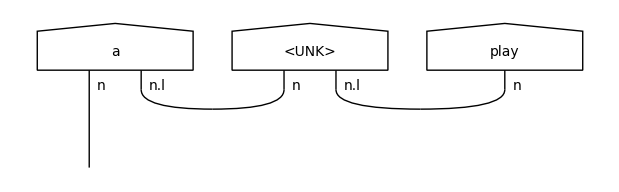

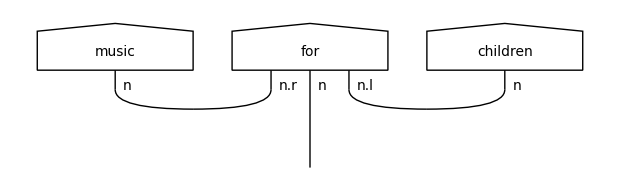

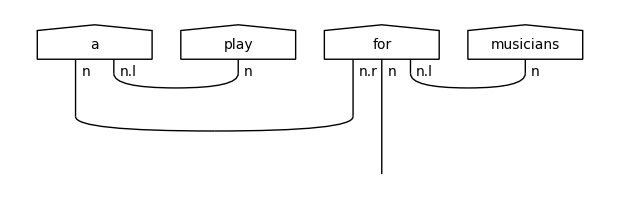

In [10]:
for d in rewritten_train_diagrams:
    d.draw(figsize=(6,3))

These `UNK` representations will be used in the testing diagrams in place of the unseen noun ("ball") and adjective ("nice").

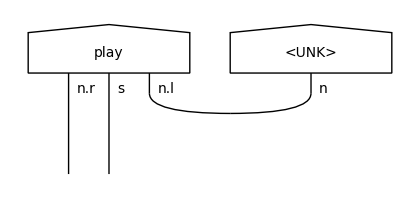

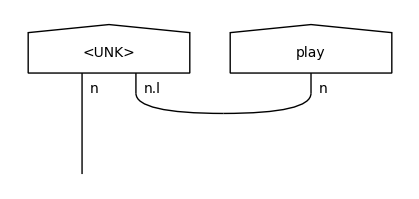

In [11]:
for d in rewritten_test_diagrams:
    d.draw(figsize=(4,2))